# 多成分雑音除去（Wiener Filter Matrix / MIMO 解析）

複数のノイズ源が互いに相関を持っていたり、センサー同士が物理的に結合（クロストーク）している場合、単純な1対1のノイズ除去では不十分です。例えば、2つの地面振動センサーが互いに近くにあり、同じ振動源を異なる比率で捉えている場合、それぞれを独立にメイン信号から引いてしまうと、ノイズを二重に引いてしまい（Over-subtraction）、逆にノイズを増やしてしまう可能性があります。

このような多入力・単出力（MISO）や多入力・多出力（MIMO）のシステムでは、**ウィーナーフィルター行列 (Wiener Filter Matrix)** を用いた多項式（多重相関）解析が有効です。

このチュートリアルでは、以下の流れで解析を実演します。

1.  **特性のあるセンサーデータの生成**: 周波数特性（低域・広域・共振）を持つノイズ源が混ざり合った「相関のある補助チャンネル」をシミュレーションします。
2.  **CSD行列の計算**: `csd_matrix()` を用いて、補助チャンネル間の相関行列 $C_{XX}$ とメインチャンネルとの相互相関行列 $C_{YX}$ を作成します。
3.  **MIMO伝達関数の推定**: 行列演算 $H = C_{YX} C_{XX}^{-1}$ を行い、結合を考慮した真の寄与（結合関数）を推定します。
4.  **ノイズ除去**: 推定された $H$ を用いてノイズを投影・除去し、独立なノイズ源の寄与が正しく差し引かれることを確認します。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from gwexpy import TimeSeries, TimeSeriesDict, FrequencySeriesDict
from gwexpy.noise.asd import from_pygwinc
from gwexpy.noise.wave import from_asd

## 1. スペクトル構造を持つ信号のシミュレーション

独立な物理ノイズ $S_1$ (低域成分) と $S_2$ (広域+共振) があり、2つのセンサー $AUX_1, AUX_2$ がそれらの「混合」を測定している状況を作成します。


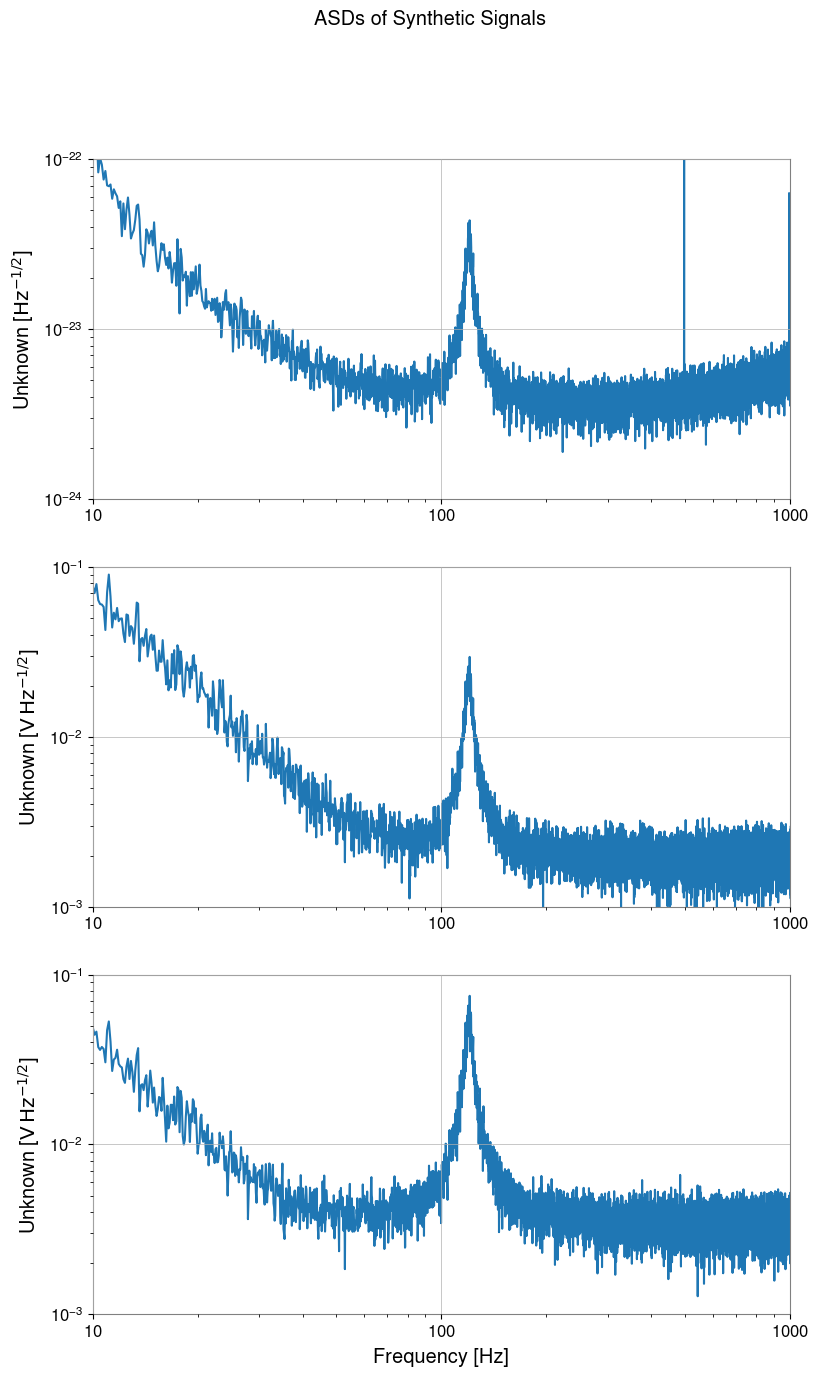

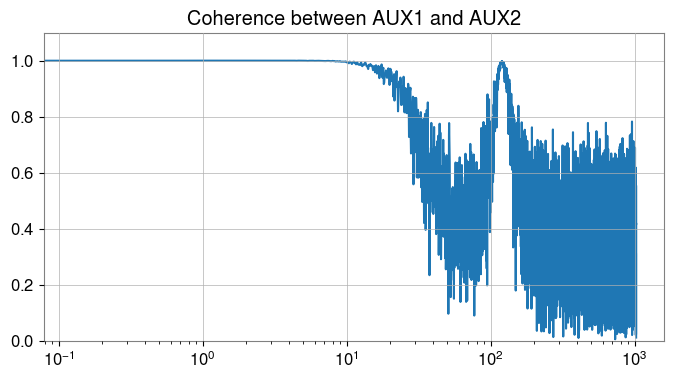

In [2]:
fs = 2048.0
duration = 64.0
t = np.arange(0, duration, 1/fs)
n = len(t)

np.random.seed(123)
rng = np.random.default_rng(123)

# aLIGO の感度曲線(ASD)を取得してメインチャンネルの基準ノイズに使う
fmax = fs / 2
asd_main = from_pygwinc('aLIGO', fmin=5.0, fmax=fmax, df=1.0 / duration, quantity='strain')

# --- 独立なノイズ源の生成 (スペクトル構造を持たせる) ---
# 1. 低域ノイズ (地面振動など)
b_low, a_low = signal.butter(2, 5.0, fs=fs, btype='low')
s1 = signal.lfilter(b_low, a_low, np.random.normal(0, 10.0, n))

# 2. 120Hzに共振を持つ広域ノイズ (機器の振動など)
b_band, a_band = signal.iirpeak(120.0, 30.0, fs=fs)
s2 = signal.lfilter(b_band, a_band, np.random.normal(0, 2.0, n))
s2 += np.random.normal(0, 0.1, n) # 広域ノイズを少し足す

# --- センサーへの混合 (Crosstalk) ---
# 補助センサー1: s1:s2 = 1.0 : 0.4
aux1_val = 1.0 * s1 + 0.4 * s2 + np.random.normal(0, 0.05, n)
# 補助センサー2: s1:s2 = 0.6 : 1.0
aux2_val = 0.6 * s1 + 1.0 * s2 + np.random.normal(0, 0.05, n)


tsd = TimeSeriesDict()
tsd["MAIN"] = from_asd(asd_main, duration, fs, t0=0, rng=rng).highpass(5.0)
tsd["AUX1"] = TimeSeries(aux1_val, sample_rate=fs, unit="V")
tsd["AUX2"] = TimeSeries(aux2_val, sample_rate=fs, unit="V")

# ノイズ混入
tsd["MAIN"] += tsd["AUX1"]/tsd["AUX1"].unit * tsd["MAIN"].unit *2e-22
tsd["MAIN"] += tsd["AUX2"]/tsd["AUX2"].unit * tsd["MAIN"].unit *5e-22

# 全体のスペクトルを確認
tsd.asd(fftlength=8).plot(xscale="log", yscale="log",separate=True,sharex=True).suptitle("ASDs of Synthetic Signals")
axes = plt.gcf().axes
axes[0].set_xlim(10, 1000)
axes[0].set_ylim(1e-24, 1e-22)
axes[1].set_ylim(1e-3, 1e-1)
axes[2].set_ylim(1e-3, 1e-1)
plt.show()

# 補助チャンネル同士のコヒーレンス
coh_aux = tsd["AUX1"].coherence(tsd["AUX2"], fftlength=8)
plt.figure(figsize=(8, 4))
plt.semilogx(coh_aux.frequencies, coh_aux.value)
plt.title("Coherence between AUX1 and AUX2")
plt.ylim(0, 1.1); plt.grid(True); plt.show()


## 2. 相互相関密度 (CSD) 行列の推定


In [3]:
aux_names = ["AUX1", "AUX2"]
aux_tsd = TimeSeriesDict({k: tsd[k] for k in aux_names})

# 統計的な多重相関を正しく解くため、ウィンドウ平均化したマトリックスを計算
cxx = aux_tsd.csd_matrix(fftlength=8.0)
cyx = TimeSeriesDict({"MAIN": tsd["MAIN"]}).csd_matrix(other=aux_tsd, fftlength=8.0)


## 3. 多成分ウィーナーフィルターの計算


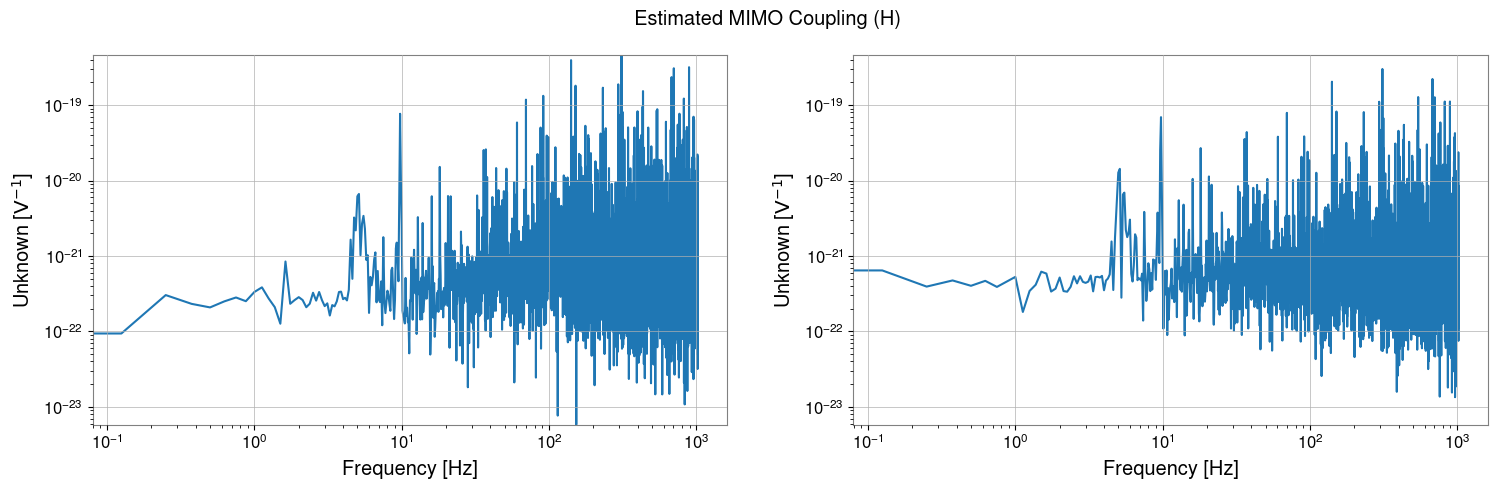

In [4]:
# 行列演算 H = Cyx @ Cxx^-1
H_lowres = cyx @ cxx.inv()

# 推定された伝達関数の表示
H_lowres.abs().plot(xscale="log", yscale="log").suptitle("Estimated MIMO Coupling (H)")
plt.show()


## 4. ノイズ投影と除去


In [5]:
# フル解像度のFFT
tsd_fft = tsd.fft()

# フィルターの補間と行列演算
H = H_lowres.interpolate(tsd_fft['MAIN'].frequencies)
X_mat = FrequencySeriesDict({k: tsd_fft[k] for k in aux_names}).to_matrix()

# 投影と減算
Y_proj = (H @ X_mat)[0, 0]
cleaned_ts = tsd['MAIN'] - Y_proj.ifft().bandpass(100,130).real

## 5. 結果の検証


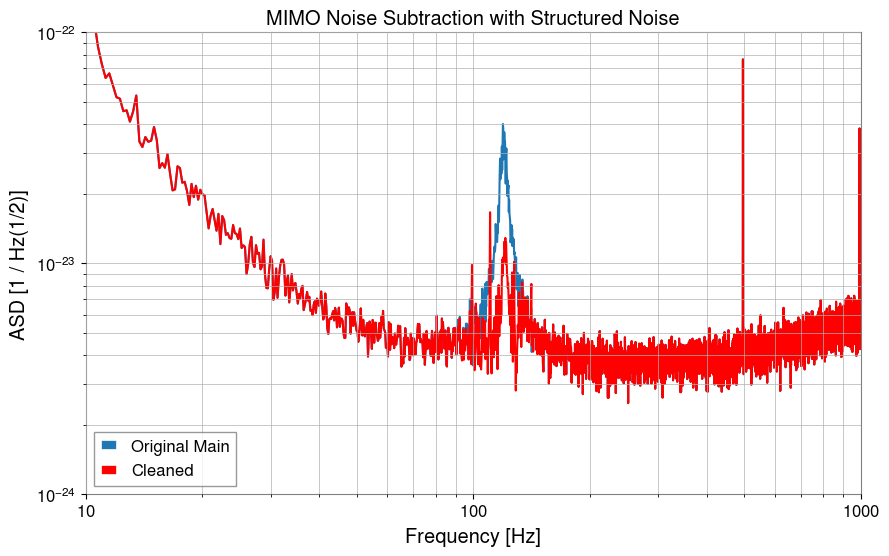

In [6]:
plot_fftlen = 4.0
asd_raw = tsd["MAIN"].asd(fftlength=plot_fftlen)
asd_cleaned = cleaned_ts.asd(fftlength=plot_fftlen)

plt.figure(figsize=(10, 6))
plt.loglog(asd_raw, label="Original Main", color="tab:blue")
plt.loglog(asd_cleaned, label="Cleaned", color="red")

plt.title("MIMO Noise Subtraction with Structured Noise")
plt.xlabel("Frequency [Hz]")
plt.ylabel(f"ASD [{asd_raw.unit}]")
plt.legend(); plt.grid(True, which="both")

plt.xlim(10, 1000)
plt.ylim(1e-24, 1e-22)
plt.show()